<a href="https://www.cognitiveclass.ai"><img src = "https://cognitiveclass.ai/wp-content/themes/bdu3.0/static/images/cc-logo.png" align = left></a>

<br>
<br>

--------------------
# Signal to Binary Files (Train&Test) 

In this notebook we read the Basic 4 dataset and convert signals into a binary file. The format of output binary file is same as MNIST.

In [1]:
!sudo pip install ibmseti

The directory '/home/nimbix/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/nimbix/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
You are using pip version 8.1.1, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import requests
import json
import ibmseti
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import os
from PIL import Image
from matplotlib import cm
from array import array

Lets first create a working folder, and set parameters:

In [3]:
ds_directory = '/tmp/SETI1_data/SETI_ds_64x128/'  # The dataset directory to write the binary files
if not os.path.exists(ds_directory):
    os.makedirs(ds_directory)
#remove its content
os.system('rm '+ds_directory+'*')
print os.popen("ls -lrt "+ ds_directory).read()


total 0



h and w are the hight and width of the images, and lengthRatio is the length of signal in ratio.

In [4]:
h = 64 # The hight of output image (bins)
w = 128 # The witdh of output image
lengthRatio = 1.0  # the length-ration of signal to be read. The higher reatio, the better resolution. E.g. 0.5 means half of time sereis.

### Get file list

I have a list of simulated files stored in an OpenStack Object Storage container that is world-readable.

In [5]:
# Images
base_url = 'https://dal.objectstorage.open.softlayer.com/v1/AUTH_cdbef52bdf7a449c96936e1071f0a46b'
container = 'simsignals_basic_v2'
# list of images
r = requests.get('https://dal.objectstorage.open.softlayer.com/v1/AUTH_cdbef52bdf7a449c96936e1071f0a46b/simsignals_files/public_list_basic_v2_26may_2017.csv')
filelist_txt = r.text

Lets create a generator to read the file:

In [6]:
def filetext_gen(filelist_txt):
    results = filelist_txt.splitlines()[1:]
    for result in results:
        yield result

This file has 4 classes:

In [7]:
dictClass = dict({u'narrowband': 2, u'narrowbanddrd': 1, u'noise': 3, u'squiggle': 0})
dictClass

{u'narrowband': 2, u'narrowbanddrd': 1, u'noise': 3, u'squiggle': 0}

# Train/Test
    
    

In [8]:
#At first, use just 20 percent and 10 percent. This will be useful 
#as you prototype. Then you can come back here and increase these
#percentages as needed.

training_percentage = 0.50
test_percentage = 0.20

assert training_percentage + test_percentage <= 1.0

number of files:

In [9]:
uuids_classes_as_list = map(lambda row:row, filetext_gen(filelist_txt))
print "found {} files".format(len(uuids_classes_as_list))

found 4000 files


Files grouped by classes:

In [10]:
uuids_group_by_class={}
for item in filetext_gen(filelist_txt): 
    uuid, sigclass =  item.split(',')
    uuids_group_by_class.setdefault(sigclass, []).append(item)


split into test and train based on classes:

In [11]:
training_set_group_by_class = {}
test_set_group_by_class = {}
for k, v in uuids_group_by_class.iteritems():
    
    total = len(v)
    training_size = int(total * training_percentage)
    test_size = int(total * test_percentage)
    
    training_set = v[:training_size]
    test_set = v[-1*test_size:]
    
    training_set_group_by_class[k] = training_set
    test_set_group_by_class[k] = test_set
    
    print '{}: training set size: {}'.format(k, len(training_set))
    print '{}: test set size: {}'.format(k, len(test_set))
    

squiggle: training set size: 500
squiggle: test set size: 200
narrowband: training set size: 500
narrowband: test set size: 200
noise: training set size: 500
noise: test set size: 200
narrowbanddrd: training set size: 500
narrowbanddrd: test set size: 200


In [12]:
all_training_set = []
for k, v, in training_set_group_by_class.iteritems():
    print k
    for item in v:
        all_training_set.append(item)
print 'number of files in the training set:' , len(all_training_set)

squiggle
narrowband
noise
narrowbanddrd
number of files in the training set: 2000


In [13]:
all_test_set = []
for k, v, in test_set_group_by_class.iteritems():
    print k
    for item in v:
        all_test_set.append(item)
print 'number of files in the test set:' ,  len(all_test_set)

squiggle
narrowband
noise
narrowbanddrd
number of files in the test set: 800


###  Send request for data, and convert signals to spectogram

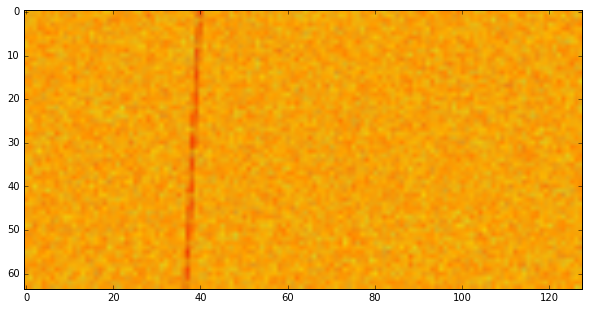

In [14]:
def get_spectrogram(fname,h,w,lengthRatio=1.0):
    
    r = requests.get('{}/{}/{}'.format(base_url, container, fname), timeout=4.0)
    if r.status_code != 200:
        print 'Failed retrieving {}'.format(fname)
        print r
        return None
    else:
        aca = ibmseti.compamp.SimCompamp(r.content)
        com_data = aca.complex_data()
        ratio = int(np.sqrt(len(com_data) *lengthRatio / (h*w)))
        if ratio == 0: 
            raise ValueError, "The selected lenght of signal is less than (Height x Width), select bigger ratio"
        elif ratio == 1:
            sig_data = com_data[:h*w].reshape(h,w)
            spec = np.abs( np.fft.fftshift( np.fft.fft(sig_data), 1) )**2
            spec = np.log(spec)
            spec = spec/np.max(spec) # Convert to float (0-1)
            image = Image.fromarray(cm.jet(spec, bytes=True)) #convert to RGB
        elif ratio > 1: # resize using IPL image
            sig_data = com_data[:h*ratio*w*ratio].reshape(h*ratio,w*ratio)
            spec = np.abs( np.fft.fftshift( np.fft.fft(sig_data), 1) )**2
            spec = np.log(spec) # Convert to float (0-255)
            spec = spec/np.max(spec) # Convert to float (0-1)
            image = Image.fromarray(cm.jet(spec, bytes=True)) #convert to RGB  
            image = image.resize((int(w), int(h)), Image.ANTIALIAS)

        
        return image
#test

img_spec = get_spectrogram('b1cc342f-eae4-442b-91de-10c9a444072e.dat',h,w, 1.0)
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(img_spec)

#### Grayscale image

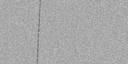

In [15]:
img = img_spec.convert("L")
imgarr = np.array(img, dtype=np.uint8) 
im = Image.fromarray(np.uint8(imgarr))
im


In [16]:
imgarr.flatten()

array([176, 175, 173, ..., 160, 185, 176], dtype=uint8)

## Write to Binary file
This binary file is same as famouse __mnist__ dataset format to be read by different image processing algorithms, learning techniques and pattern recognition methods. 

There are 4 files:  

- train-images-idx3-ubyte: training set images 
- train-labels-idx1-ubyte: training set labels 
- test-images-idx3-ubyte:  test set images 
- test-labels-idx1-ubyte:  test set labels


### Header generator

#### Notice:

- Header of Label file is 8 Bytes
- Each number (int-8bit), is one Byte in array(B)
- For header, the first 4 bytes is 2049 
- the second 4 bytes is the number of files
- for example, the header for 10 file is [0, 0, 8, 1, 0, 0, 0, 10]

In [17]:
def label_generator(ds_directory, name, data_set):
    counter = 0
    data_label = array('B')
    n = len(data_set)

    # number of files in HEX
    hexval = "{0:#0{1}x}".format(n,6)  # the result is '0x000a'

    # header for label array
    #data_label.extend(lblData)
    lb_header = array('B')
    # in the next 3 lines we create 10 bytes header
    lb_header.extend([0,0,8,1,0,0])  # -> "{0:#0{1}x}".format(2049,6) = '0x0801'
    lb_header.append(int('0x'+hexval[2:][:2],16)) # it adds 2 bytes '0x00'
    lb_header.append(int('0x'+hexval[2:][2:],16)) # it adds 2 bytes '0x0a'
    print lb_header
    with open(ds_directory + name+'-labels-idx1-ubyte','wb+') as f:
        f.write(lb_header)
        for item in data_set: 
            uuid, sigclass =  item.split(',')
            # print uuid,sigclass
            f.write(np.uint8(dictClass[sigclass]))
            counter += 1
#             if counter > n:
#                 break
        print 'The number of labels written in the binary file', counter
            
    os.system('gzip '+ ds_directory + name +'-labels-idx1-ubyte ')
    print ('done!')

In [18]:
label_generator(ds_directory, 'train', all_training_set)
label_generator(ds_directory, 'test', all_test_set)

array('B', [0, 0, 8, 1, 0, 0, 7, 208])
The number of labels written in the binary file 2000
done!
array('B', [0, 0, 8, 1, 0, 0, 3, 32])
The number of labels written in the binary file 800
done!


### Image generator

In [19]:
def image_generator(ds_directory, name, data_set):
    print 'writing to:',  ds_directory , name
    counter = 0

    data_image = array('B')

    n = len(data_set)

    # number of files in HEX
    hexval = "{0:#0{1}x}".format(n,6) 

    img_header = array('B')
    img_header.extend([0,0,8,1,0,0])
    img_header.append(int('0x'+hexval[2:][:2],16))
    img_header.append(int('0x'+hexval[2:][2:],16))
    if max([w,h]) <= 255:
        img_header.extend([0,0,0,h,0,0,0,w])
    else:
        hex_h = "{0:#0{1}x}".format(h,6)
        img_header.extend([0,0])
        img_header.append(int('0x'+hex_h[2:][:2],16))
        img_header.append(int('0x'+hex_h[2:][2:],16))
        hex_w = "{0:#0{1}x}".format(w,6)
        img_header.extend([0,0])
        img_header.append(int('0x'+hex_w[2:][:2],16))
        img_header.append(int('0x'+hex_w[2:][2:],16))
        #raise ValueError('Image exceeds maximum size: 256x256 pixels');
    img_header[3] = 3 # Changing MSB for image data (0x00000803)
    #print img_header


    with open(ds_directory+name+'-images-idx3-ubyte','wb+') as f:
        f.write(img_header)
        for item in data_set: 
            uuid, sigclass =  item.split(',')
            file_name = uuid +'.dat'
            #print file_name, sigclass
            img_spec = get_spectrogram(file_name, h, w, lengthRatio)
            # convert to grayscale: int(0-255)
            gimg = img_spec.convert("L")
            imgarr = np.array(gimg, dtype=np.uint8) #convert to array
            flat_array = imgarr.flatten()
            f.write((flat_array))
            counter += 1
            if counter%100 == 0:
                print('Processed files: '+str(counter))
#             if counter > n:
#                 break
        print 'The number of images written in the binary file', counter
    print 'Compressing .. '
    os.system('gzip '+ ds_directory + name +'-images-idx3-ubyte '+ name +'-images-idx3-ubyte.gz')

'problematic files, to be filtered'
'1c396696-baac-418b-9c14-bd798172ac61.dat'

In [21]:
image_generator(ds_directory, 'train', all_training_set)
image_generator(ds_directory, 'test', all_test_set)

writing to: /tmp/SETI1_data/SETI_ds_64x128/ test
Processed files: 100
Processed files: 200
Processed files: 300
Processed files: 400
Processed files: 500
Processed files: 600
Processed files: 700
Processed files: 800
The number of images written in the binary file 800
Compressing .. 


In [22]:
!ls /tmp/SETI1_data/SETI_ds_64x128/

test-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
test-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


## Zip everything

## Verify the binary files
Lets read the binary file and plot an image

In [23]:
print os.popen("ls -lrt "+ ds_directory).read()

total 15412
-rw-rw-r-- 1 nimbix nimbix       71 Oct 23 18:12 train-labels-idx1-ubyte.gz
-rw-rw-r-- 1 nimbix nimbix       64 Oct 23 18:12 test-labels-idx1-ubyte.gz
-rw-rw-r-- 1 nimbix nimbix 11261768 Oct 23 18:17 train-images-idx3-ubyte.gz
-rw-rw-r-- 1 nimbix nimbix  4505667 Oct 23 18:28 test-images-idx3-ubyte.gz



### Header read

In [24]:
import numpy as np
import gzip
def _read32(bytestream): # this function reads 4 Bytes (32 bit)
  dt = np.dtype(np.uint32).newbyteorder('>')
  return np.frombuffer(bytestream.read(4), dtype=dt)[0] # it reads 4 bytes, and convert it into intiger

with open(ds_directory+'train-labels-idx1-ubyte.gz', 'rb') as f:
    with gzip.GzipFile(fileobj=f ) as bytestream:
     print  _read32(bytestream)
     num_items = _read32(bytestream)
     print num_items
     buf = bytestream.read(num_items)
     labels = np.frombuffer(buf, dtype=np.uint8)
     print labels

2049
2000
[0 0 0 ..., 1 1 1]


# Image read

In [25]:
import numpy as np
import gzip
def _read32(bytestream):
  dt = np.dtype(np.uint32).newbyteorder('>')
  return np.frombuffer(bytestream.read(4), dtype=dt)[0]

with open(ds_directory+'train-images-idx3-ubyte.gz', 'rb') as f:
    with gzip.GzipFile(fileobj=f ) as bytestream:
        magic = _read32(bytestream)
        if magic != 2051:
            raise ValueError('Invalid magic number %d in MNIST image file: %s' %(magic, f.name))
        num_images = _read32(bytestream)
        rows = _read32(bytestream)
        cols = _read32(bytestream)
        buf = bytestream.read(rows * cols * num_images)
        print(magic,num_images,rows,cols,)
        
        data = np.frombuffer(buf, dtype=np.uint8)
        data = data.reshape(num_images, rows, cols, 1)
# magic, num, rows, cols = struct.unpack(">IIII", bytestream.read(16))


(2051, 2000, 64, 128)


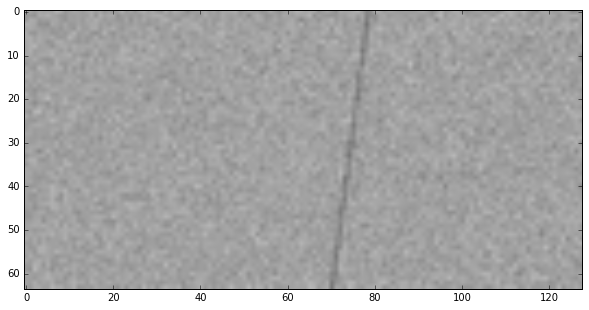

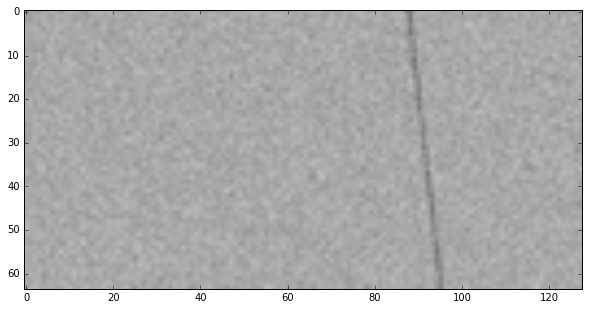

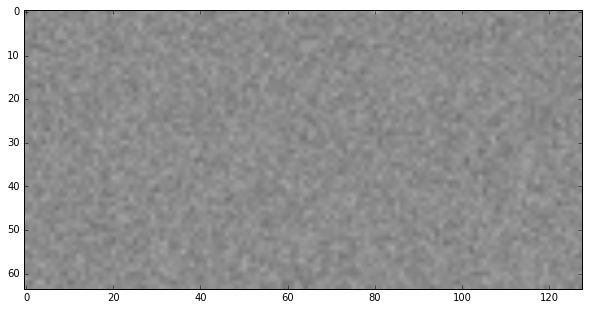

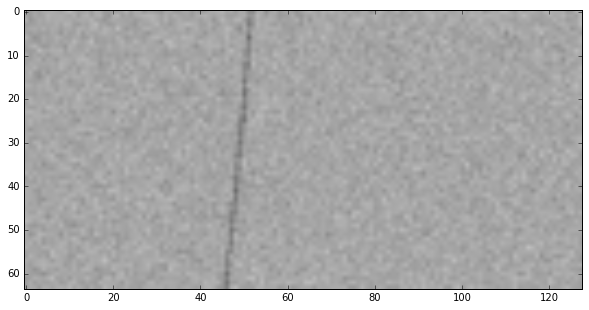

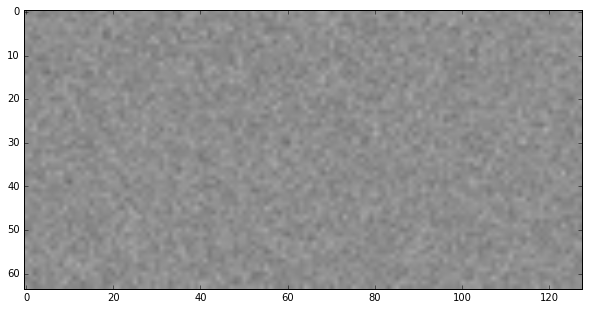

In [26]:
import random
for i in range(5):
    num = random.randint(1,num_images)
    #print num
    gray_y = data[num].reshape(h,w)
    img = Image.fromarray(np.float32(gray_y))
    #print (img.mode)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(img)

In [27]:
gray_y

array([[123, 131, 146, ..., 134, 135, 136],
       [145, 143, 141, ..., 132, 158, 145],
       [153, 147, 156, ..., 149, 146, 147],
       ..., 
       [127, 140, 149, ..., 135, 148, 146],
       [143, 135, 123, ..., 132, 142, 149],
       [155, 140, 127, ..., 138, 144, 144]], dtype=uint8)

### Verify the binary files by reader class
__SETI.py__ is a helper class, identical to mnist dataset reader, to easily read dataset, one-hot coding, and read images as batch.

In [28]:
!wget -q --output-document SETI.zip  https://ibm.box.com/shared/static/jhqdhcblhua5dx2t7ixwm88okitjrl6l.zip
!unzip -o SETI.zip
import SETI

Archive:  SETI.zip
  inflating: SETI.py                 
  inflating: __MACOSX/._SETI.py      


In [29]:
SETIds = SETI.read_data_sets(ds_directory, one_hot=True, validation_size=0)
SETIds.train.num_examples

Extracting /tmp/SETI1_data/SETI_ds_64x128/train-images-idx3-ubyte.gz
Extracting /tmp/SETI1_data/SETI_ds_64x128/train-labels-idx1-ubyte.gz
Extracting /tmp/SETI1_data/SETI_ds_64x128/test-images-idx3-ubyte.gz
Extracting /tmp/SETI1_data/SETI_ds_64x128/test-labels-idx1-ubyte.gz


2000

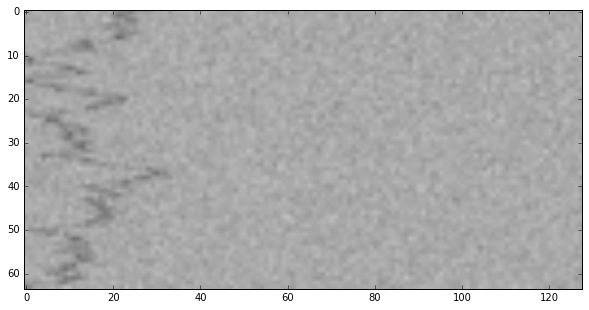

In [30]:
gray_y = SETIds.train.images[0].reshape(h,w)
img = Image.fromarray(gray_y*255)
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(img)

### Authors

<div class="teacher-image" style="    float: left;
    width: 115px;
    height: 115px;
    margin-right: 10px;
    margin-bottom: 10px;
    border: 1px solid #CCC;
    padding: 3px;
    border-radius: 3px;
    text-align: center;"><img class="alignnone wp-image-2258 " src="https://ibm.box.com/shared/static/tyd41rlrnmfrrk78jx521eb73fljwvv0.jpg" alt="Saeed Aghabozorgi" width="178" height="178" /></div>
#### Saeed Aghabozorgi

[Saeed Aghabozorgi](https://ca.linkedin.com/in/saeedaghabozorgi), PhD is Sr. Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

